In [2]:
import pandas as pd
import re
import warnings
warnings.filterwarnings('ignore')

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
pd.set_option('display.max_rows', None)
from joblib import dump, load

In [3]:
import nltk as nltk
import nltk.corpus 
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [4]:
import multiprocessing
from pandarallel import pandarallel

num_processors = multiprocessing.cpu_count()
workers = num_processors-1
print(f'Available CPUs: {num_processors}')

Available CPUs: 12


In [5]:
pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False)

INFO: Pandarallel will run on 11 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [4]:
directory = 'https://storage.googleapis.com/msca-bdp-data-open/yelp/'
fileName = 'yelp_train_sentiment.json'

path = directory + fileName

In [5]:
%%time

df = pd.read_json(path, orient='records', lines=True)
df.shape

CPU times: total: 2.7 s
Wall time: 35.7 s


(255717, 3)

In [6]:
df.head(2)

,text,label,lang
0,I love Deagan's. I do. I really do. The atmosp...,1,en
1,I love the classes at this gym. Zumba and. Rad...,1,en


In [7]:
X = df['text']
y = df['label']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, train_size = 0.85, test_size = 0.15)

print(f"Training records, X_train: {X_train.shape} y_train: {y_train.shape}")
print(f"Testing records, X_test: {X_test.shape} y_test: {y_test.shape}")

Training records, X_train: (217359,) y_train: (217359,)
Testing records, X_test: (38358,) y_test: (38358,)


In [9]:
pipe_logreg = make_pipeline(
    TfidfVectorizer(lowercase=False, stop_words='english', ngram_range=(1,3)),
    LogisticRegression(max_iter=1000))

In [10]:
pipe_logreg.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(lowercase=False, ngram_range=(1, 3),
                                 stop_words='english')),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [11]:
y_pred_logreg = pipe_logreg.predict(X_test)

In [12]:
print(classification_report(y_test, y_pred_logreg))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97     19199
           1       0.97      0.96      0.97     19159

    accuracy                           0.97     38358
   macro avg       0.97      0.97      0.97     38358
weighted avg       0.97      0.97      0.97     38358



In [14]:
%time 
dump(pipe_logreg, "logreg.joblib")

In [15]:
df_clean = pd.read_parquet(r'Preprocessing_3_no_ai.parquet', engine='pyarrow')
df_clean.shape

(131569, 4)

In [15]:
df_clean.head(2)

,date,clean_title_v3,clean_text_v5,clean_text_no_ai
0,2020-02-26,LegalTech Artificial Intelligence Market Tech...,LegalTech Artificial Intelligence Market Techn...,legaltech market advancement future scope ca...
2,2020-03-13,Covid un messaggio dai ricercatori italiani ai...,Covid un messaggio dai ricercatori italiani ai...,covid un messaggio d ricercatori italiani col...


In [20]:
test = df_clean['clean_title_v3']
y_pred = pipe_logreg.predict(test)

In [21]:
df_clean['sentiment_model'] = y_pred

In [22]:
df_clean['sentiment_model_cat'] = df_clean['sentiment_model'].map({0: 'Negative', 1: 'Positive'})

In [23]:
df_clean['sentiment_model_cat'].value_counts(normalize=True)

sentiment_model_cat
Negative    0.664837
Positive    0.335163
Name: proportion, dtype: float64

In [16]:
test1 = df_clean['clean_text_v5']
y_pred1 = pipe_logreg.predict(test1)

In [17]:
df_clean['sentiment_model_text'] = y_pred1

In [18]:
df_clean['sentiment_model_cat_text'] = df_clean['sentiment_model_text'].map({0: 'Negative', 1: 'Positive'})

In [19]:
df_clean['sentiment_model_cat_text'].value_counts(normalize=True)

sentiment_model_cat_text
Negative    0.633151
Positive    0.366849
Name: proportion, dtype: float64

In [24]:
df_clean.head()

,date,clean_title_v3,clean_text_v5,clean_text_no_ai,sentiment_model_text,sentiment_model_cat_text,sentiment_model,sentiment_model_cat
0,2020-02-26,LegalTech Artificial Intelligence Market Tech...,LegalTech Artificial Intelligence Market Techn...,legaltech market advancement future scope ca...,1,Positive,1,Positive
2,2020-03-13,Covid un messaggio dai ricercatori italiani ai...,Covid un messaggio dai ricercatori italiani ai...,covid un messaggio d ricercatori italiani col...,1,Positive,0,Negative
7,2021-02-25,MulticoreWare Inc Becomes CEVAs Trusted Partne...,MulticoreWare Inc Becomes CEVAs Trusted Partne...,multicoreware inc becomes cevas trusted partne...,0,Negative,0,Negative
8,2022-10-06,Healthcare Artificial Intelligence Market Anal...,Healthcare Artificial Intelligence Market Anal...,healthcare market analysis forecast next year...,1,Positive,0,Negative
9,2020-04-29,Artificial Intelligence As A Service Market Op...,Artificial Intelligence Service Market Opportu...,service market opportunities market analysis ...,1,Positive,0,Negative


In [32]:
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

def get_sentiment_scores(text):
    scores = sia.polarity_scores(text)
    return scores

df_clean['sentiment_vader'] = df_clean['clean_title_v3'].apply(get_sentiment_scores)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [33]:
df_clean.head()

,date,clean_title_v3,clean_text_v5,clean_text_no_ai,sentiment_model,sentiment_model_cat,sentiment_vader
0,2020-02-26,LegalTech Artificial Intelligence Market Tech...,LegalTech Artificial Intelligence Market Techn...,legaltech market advancement future scope ca...,1,Positive,"{'neg': 0.0, 'neu': 0.838, 'pos': 0.162, 'comp..."
2,2020-03-13,Covid un messaggio dai ricercatori italiani ai...,Covid un messaggio dai ricercatori italiani ai...,covid un messaggio d ricercatori italiani col...,0,Negative,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
7,2021-02-25,MulticoreWare Inc Becomes CEVAs Trusted Partne...,MulticoreWare Inc Becomes CEVAs Trusted Partne...,multicoreware inc becomes cevas trusted partne...,0,Negative,"{'neg': 0.0, 'neu': 0.683, 'pos': 0.317, 'comp..."
8,2022-10-06,Healthcare Artificial Intelligence Market Anal...,Healthcare Artificial Intelligence Market Anal...,healthcare market analysis forecast next year...,0,Negative,"{'neg': 0.0, 'neu': 0.744, 'pos': 0.256, 'comp..."
9,2020-04-29,Artificial Intelligence As A Service Market Op...,Artificial Intelligence Service Market Opportu...,service market opportunities market analysis ...,0,Negative,"{'neg': 0.0, 'neu': 0.678, 'pos': 0.322, 'comp..."


In [34]:
df_clean['sentiment_vader'] = df_clean['sentiment_vader'].astype(str)
df_split = df_clean['sentiment_vader'].str.strip('{}').str.split(', ', expand=True)

df_clean['neg_vader'] = 0.0
df_clean['neu_vader'] = 0.0
df_clean['pos_vader'] = 0.0
df_clean['comp_vader'] = 0.0

for i in range(df_split.shape[1] - 1):
    key_value = df_split[i].str.split(':', expand=True)
    key = key_value[0].str.strip().str.replace("'", "")
    value = pd.to_numeric(key_value[1].str.strip())
    df_clean.loc[key == 'neg', 'neg_vader'] = value
    df_clean.loc[key == 'neu', 'neu_vader'] = value
    df_clean.loc[key == 'pos', 'pos_vader'] = value
    df_clean.loc[key == 'compound', 'comp_vader'] = value

In [35]:
df_clean.head(1)

,date,clean_title_v3,clean_text_v5,clean_text_no_ai,sentiment_model,sentiment_model_cat,sentiment_vader,neg_vader,neu_vader,pos_vader,comp_vader
0,2020-02-26,LegalTech Artificial Intelligence Market Tech...,LegalTech Artificial Intelligence Market Techn...,legaltech market advancement future scope ca...,1,Positive,"{'neg': 0.0, 'neu': 0.838, 'pos': 0.162, 'comp...",0.0,0.838,0.162,0.0


In [25]:
df_clean.to_parquet('Sentiment_final.parquet')

In [10]:
df_clean.to_parquet('Sentiment_log_vader.parquet')

In [37]:
df_pos.to_csv('Positive_sentiment.csv')

In [38]:
df_neg.to_csv('Negative_sentiment.csv')

In [8]:
df = pd.read_parquet('Sentiment_log_vader.parquet')

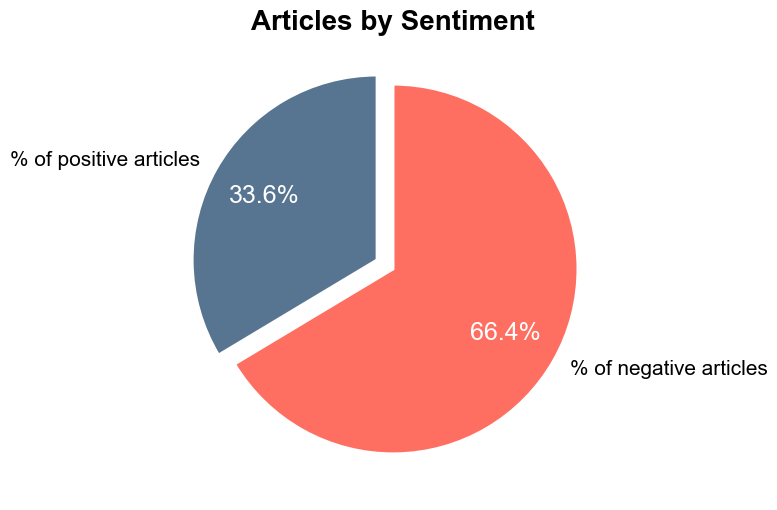

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

title = ['% of positive articles', '% of negative articles']
val = [61988, 122500]
colors = ['#577590','#FF6F61']
explode = (0.1, 0)
total = sum(val)

def my_fmt(x):
    return '{:.1f}%'.format(x)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

patches, texts, autotexts = ax.pie(val, 
                                   colors=colors, labels=title, autopct=my_fmt, startangle=90, explode=explode, 
                                   pctdistance=0.7, labeldistance=1.1, 
                                   textprops={'fontsize': 15, 'color': 'black'}, wedgeprops={'linewidth': 2, 'edgecolor': 'white'})

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(18)

# Add title
ax.set_title('Articles by Sentiment', fontsize=20, fontweight='bold')

plt.show()